In [1]:
#import statements
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from scipy.optimize import minimize
import ipywidgets as widgets
from IPython.display import display
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Making Predictions
#### Michelle Wilkerson

The goal of this lesson is to explore different models and methods for making predictions using data related to gray wolves and Yellowstone National Park. Each model comes with its own pros and cons that need to be considered, and we hope that by the end of this exploration, you will be able to think about possible benefits that come with different methodologies and be more critical of prediction techniques that you encounter.

### Background

Yellowstone is a national park located in Wyoming, Montana, and Idaho, covering almost 3,500 square miles. It became the first National Park in the United States in 1872 under President Ulysses S. Grant. It is thought to not only be the first National Park in the United states, but also the first national park in the world.

<img src=http://d1njyp8tsu122i.cloudfront.net/wp-content/uploads/map-lodging-by-state_680x392.jpg width=600>

Yellowstone is famous primarily for two things:

- First, for its geysers and hot springs. It contains about half of the world’s geysers, with over 450 active geysers. For comparison, the next second largest collection of active geysers has about 200. It is home to the world's tallest active geyser, Steamboat Geyser, and to the famous <a href="https://youtu.be/h9uRaEoEV-U?t=1m36s">Old Faithful Geyser</a>. 

- The park is also famous for its wildlife. According to the National Park Service, Yellowstone is "home to the largest concentration of mammals in the lower 48 states," with 67 species of mammals, and over 325 different species of birds, fish, amphibians, and reptiles.

Despite being a National Park, the animals of Yellowstone were not originally offered special protections.
The <a href=https://www.nps.gov/yell/learn/management/yellowstoneprotectionact1872.htm>Yellowstone National Park Protection Act</a> said that the Secretary of the Interior would "provide against the wanton destruction of the fish and game found within [Yellowstone]," but made no specific provisions, and left wiggle room for interpretation. Of semi-recent attention has been the status of gray wolves in the park -- which are neither game nor fish, so under the Protection Act, were left on their own. 

<img src=http://d1njyp8tsu122i.cloudfront.net/wp-content/uploads/Yellowstone-Wildlife-Wolf-11.jpg width=400>

Historically, gray wolves roamed about <a href="https://www.nwf.org/Wildlife/Wildlife-Library/Mammals/Gray-Wolf.aspx">two-thirds</a> of the United States, with numbers estimated to be over a quarter-million, but by the 1960s, the only wild gray wolves in the lower 48 states were restricted to <a href="http://www.missionwolf.org/page/wild-wolf-history/">Michigan and Minnesota</a>.

With America's westward expansion came the tolling of the bells for wolves. Not only did they have to compete with settlers for space, but they were also hunted. Farmers and ranchers feared for their livestock, and successfully advocated for programs to reduce gray wolf populations. Beginning in the 19th century and continuing into the 20th, there were <a href="https://www.fws.gov/midwest/wolf/aboutwolves/biologue.htm">government programs that offered bounties for each wolf killed</a>. In 1880, the superintendent of Yellowstone had stated that <a href="http://www.pbs.org/wnet/nature/the-wolf-that-changed-america-wolf-wars-americas-campaign-to-eradicate-the-wolf/4312/">"the value of their [wolves and coyotes] hides and their easy slaughter with strychnine-poisoned carcasses have nearly led to their extermination.”</a> By the end of the 1920s, gray wolves had disappeared from most of the United States. 

<img src=http://www.hcn.org/issues/46.21/have-returning-wolves-really-saved-yellowstone/yellowstonewolves1-jpg/@@images/7fdf9c1c-9425-45dd-99a7-fe6f43ffa3a1.jpeg width=400>

In 1973, Greater Yellowstone was named as one of three recovery areas for the endangered gray wolf. From 1995 to 1997, 41 wild wolves from Montana and Canada were released in Yellowstone National Park, where their populations have been climbing since. 

#### Wolves in Yellowstone
Wolves in Yellowstone primarily feed on hooved animals, the most common being elk, and deer and smaller animals during the summer. When the wolves were reintroduced to the park, of course we would expect some sort of effect on the populations of those animals of prey. In this notebook, we are going to investigate what those effects were on the elk populations, and also on the wolf populations.

Before we begin analyzing our data, we need to run some cells of code. You don't need to know what these cells are doing in any detail, for now. To run a cell of code, click on the cell, then type `SHIFT-ENTER` or simply click the button on the toolbar at the top of the page that looks like ▶| . Run each cell of code as you work down the notebook, in the order they are placed. Some cells rely on others above it, so if you don't run them in order, you may encounter some puzzling errors.

Our first data set contains the wolf and elk populations from 1994 to 2012, though there are some years missing in the late 90s. Run the cell below to view a print-out of the table we will be working with.

In [2]:
# reading in our data from an existing file
data = pd.read_csv('wolf_and_elk_in_yellowstone.csv', thousands=',').drop('Notes', axis=1).dropna().reset_index(drop=True)
data

,Year,Elk Population,Wolf Population
0,1994,19045.0,0.0
1,1995,16791.0,0.0
2,1999,14538.0,118.0
3,2000,13400.0,177.0
4,2001,11969.0,227.0
5,2002,9215.0,271.0
6,2003,9215.0,301.0
7,2004,8335.0,324.0
8,2005,9545.0,325.0
9,2006,6588.0,390.0


To get a sense of the data, it is helpful to visualize it with graphs. The cell below constructs two graphs from the data table above and plots the change in each animal's population numbers over time.

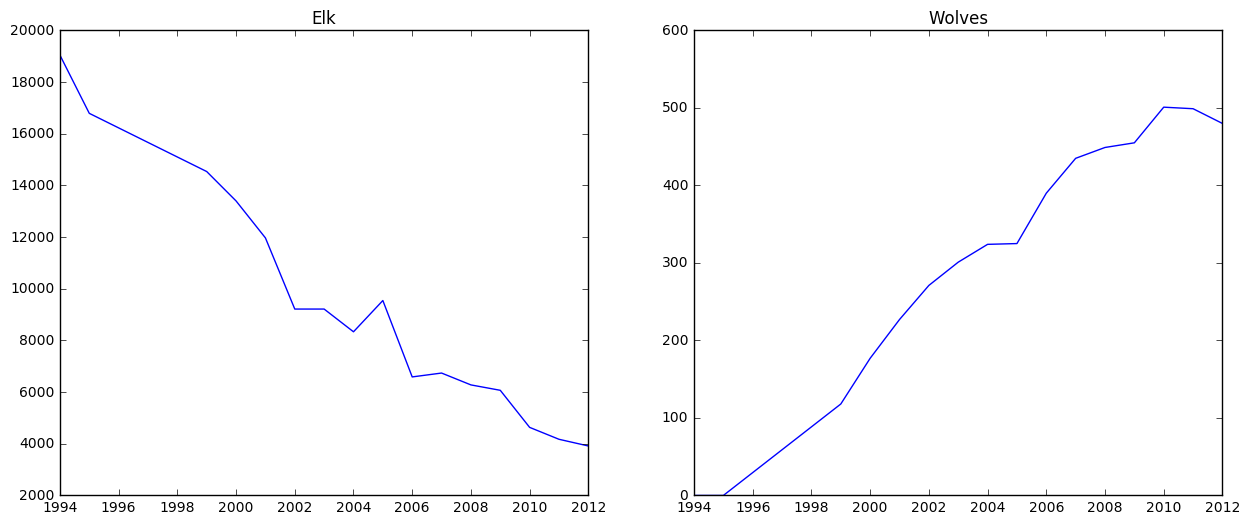

In [3]:
f, axs = plt.subplots(1,2,figsize=(15, 6))

axs[0].plot(data['Year'], data['Elk Population'])
axs[0].set_title('Elk')

axs[1].plot(data['Year'], data['Wolf Population'])
axs[1].set_title('Wolves')

Plotting the populations separately makes it difficult to see the the absolute changes in population relative to one another, so next, we will plot them on the same y-axis.

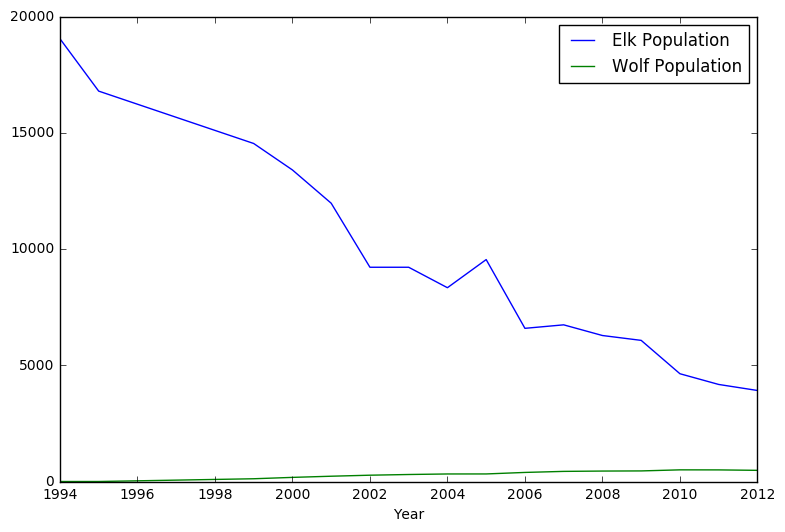

In [4]:
data.plot('Year', figsize=(9,6))

Since the scale of the absolute numbers for both animals are so different, another helpful view may be to look at the percent change in population from year to year. First we have to write a function that will set up our visualization:

In [5]:
def percent_changing(periods=1):
    percent_changed = data.pct_change(periods)
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    plt.plot(data['Year'], percent_changed['Elk Population'], c='b')
    plt.plot(data['Year'], percent_changed['Wolf Population'], c='g')
    plt.axhline(y=0, c="r")
    plt.legend()
    ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
    plt.show()

Play with the slider to increase the length of the period (the number of years) that the percent change is measured over.

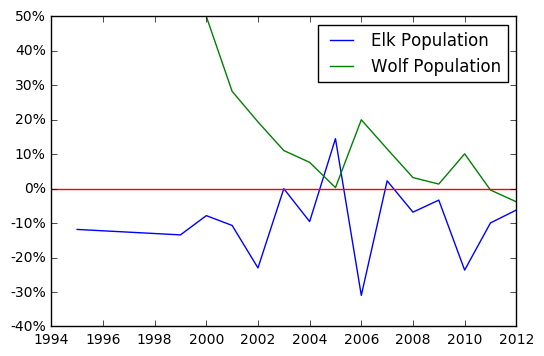

In [6]:
slider = widgets.IntSlider(min=1,max=6,step=1,value=1)
display(widgets.interactive(percent_changing, periods=slider))

<font color="blue">Question:</font> Based on the data and the graphs above, what do you think is going on with the wolf and elk populations? How do you think they will change going forward? Are they close to equilibrium?

*Write your response in the cell below, then type*  `SHIFT-ENTER`

<font color="blue">Question: </font> How do you think the changing populations of wolves and elk will impact Yellowstone park and its other animal populations? Specifically, how do you think these trends will affect the populations of wolves' other prey? What about other predatory species that also hunt those prey? How about flora populations?

*Write your response in the cell below, then type*  `SHIFT-ENTER`

### Prediction

Prediction is a powerful tool that we can use to make guesses about how data will look in the future based on previous trends. We are going to start discussing some basic prediction techniques, then move on to some more complex techniques to predict how the populations of the animals we've been talking about might look in the future.

#### Single Point Model

First, the Single Point model. This method of prediction takes one data point from our existing data and uses it to predict the populations for the next year. 

<font color='blue'>Question:</font> What issues might arise from using this method?

#### Linear Regression Model for Predicting Population

Linear regression can be done in two ways: First, we can create a regression line using all of the data points that we currently have to make a prediction about the population in future years. We could also use $N$-most recent points from our data set to make a prediction about future years' populations, rather than using all of our data.

<font color='blue'>Question:</font> Think about the differences between these two models. How are they similar? How are the findings/conclusions similar or different? What are the pros and cons of each?

In the cell below, we have some code that implements a linear regression model on our data. We will use this to investigate how changing the number of data points that we consider when doing regression influences the prediction of the next year's population. 

Run the cell below with `SHIFT-ENTER` to write a function that will set up our visulization:

In [7]:
def regressiont(included_points=16):
    
    ignore = 16 - included_points  #indexes to ignore
    
    #prediction values
    yp = data['Wolf Population'][ignore:]
    tp = data['Year'][ignore:]
    
    #values
    y = data['Wolf Population']
    t = data['Year']
    
    #loss function
    def res(pars):
        a, b = pars
        yp_hat = a + b * tp
        res = yp - yp_hat
        return sum(res**2)
    
    #optimal paramters
    a, b = minimize(res, (-6.06621468e+04,   3.04230758e+01)).x
    
    #parameters for constant
    if included_points == 1:
        a, b = 480, 0
    
    y_hat = a + b * t  #precited values
    fitline = [y_hat.iloc[0], y_hat.iloc[-1]]  #fit line end points
    fittime = [t.iloc[0], t.iloc[-1]]  #fit line time values
    
    y_prime = a + b * 2013  #predicted point
    
    ax1 = plt.scatter(t, y, c='b')  #points
    ax2 = plt.plot(fittime, fitline, 'r--')  #fitline
    ax3 = plt.plot(tp, yp, 'rs')  #points used to predict
    ax4 = plt.scatter(t.iloc[-1] +1, y_prime, c='g', marker='^')  #predicted point
    
    #graph labels
    plt.xticks(t.append(pd.Series([2013]))[::2])
    plt.xlabel('Year')
    plt.ylabel('Wolf Popultion')
    
    #display graph and predicted value
    plt.show()
    print('Predicted 2013 wolf population:', round(y_prime))

Now run the cell below and you'll see a visualization with a slider bar that allows you to select the number of data points to consider for the linear regression model. Try to take note of how the prediction for the population number is affected when you consider more vs. fewer data points in the regression model.  

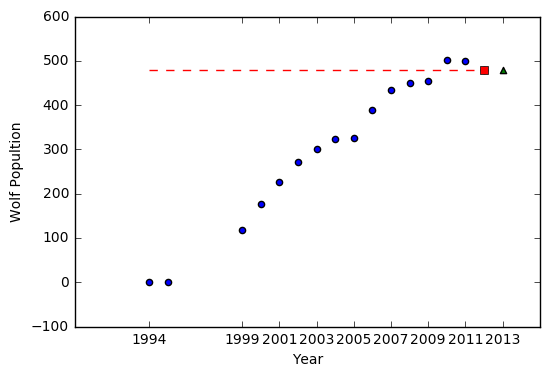

Predicted 2013 wolf population: 480


In [8]:
p_slider = widgets.IntSlider(min=1, max=16, step=1, value=1)
w=widgets.interactive(regressiont,included_points=p_slider)
display(w)

#### K-Nearest Neighbor Model for Predicting Population

K-Nearest Neighbors (a.k.a. kNN) is an algorithm used for prediction that compares features of a new data point to the $K$ existing data points that are closest to it ("close"ness depending on the measures of similarity you decide to use) to make a prediction about that data point.

A basic example of kNN regression is using the height of neighboring buildings to predict the height of a new one. In this example, if we're predicting the height of a new building in downtown Manhattan, it doesn't matter what the height of buildings are in Cedar Rapids, Iowa, it's more helpful to concentrate on the height of other skyscrapers in Manhattan. We might want to predict the number of stories that a new Manhattan apartment complex will have based on the apartment complexes that are around it.

In a similar line of thinking, just as we were selecting points to include for our linear regression, we might want to have our model only use the most relevant data points when predicting a new one.

Let's write a function that will set this up for us:

In [11]:
def knn(neighbors=1):
    model = KNeighborsRegressor(neighbors)

    X = np.array([[-1, -1.5], [-2, -1.5], [-3, -2], [1, 1], [2, 1], [3, 3]])
    random_y_values = np.array([2,3,4,5,4,1])

    to_predict = [0,0]
    
    model.fit(X, random_y_values)
    dist, ind = model.kneighbors([to_predict])

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

    circle = plt.Circle(to_predict, max(dist[0]), color='g', alpha=.2)
    axes[0].add_artist(circle)

    axes[0].plot(to_predict[0], to_predict[1],'x', color='g', mew=3)

    axes[0].scatter(X[:,0], X[:,1], color='black')


    closest_points = X[ind[0]]
    
    axes[0].set_title('Distances')
    x_coords = closest_points.transpose()[0]
    y_coords = closest_points.transpose()[1]
    axes[0].scatter(x_coords, y_coords, color='r')
    
    for i in range(len(random_y_values)):
        position = X[i]
        axes[0].text(position[0]-.05, position[1]+.07, str(random_y_values[i]))
    
    
    num_points = len(ind[0])
    axes[1].set_xlim([0,7])
    axes[1].set_ylim([0,6])

    
    
    values = []
    for i in range(num_points):
        value = random_y_values[ind[0][i]]
        axes[1].vlines(x=i+1, ymin=0, ymax=value,
                       color='r', linewidths=15)
        values.append(value)
    axes[1].hlines(y=np.mean(values), xmin=0, xmax=12,
                  linestyles='dashed', linewidths=2, color='g')

    axes[1].set_title('Values of k closest')
    axes[1].set_xlabel('k')
    axes[1].set_ylabel('Value')
    plt.show()
    print('Predicted Value: ', np.mean(values))

Now we can use another slider to change the number of closest observations the model will use in predicting the next observation.

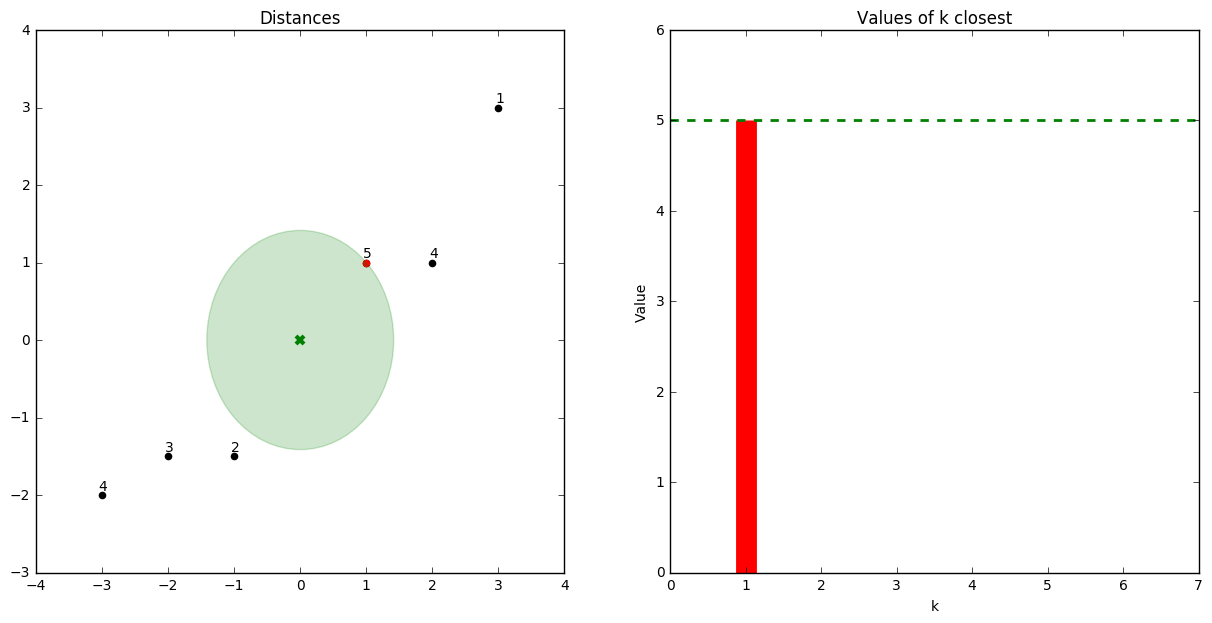

Predicted Value:  5.0


In [12]:
slider = widgets.IntSlider(min=1,max=6,step=1,value=1)
display(widgets.interactive(knn, neighbors=slider))

Prey is a very important factor in predator-prey interaction with a profound effect on the wolf population. Predators kill and eat other organisms, their prey. If or when a predator runs out of prey, they run the risk of dying out. Usually, the populations of predators and prey in an ecosystem oscillate in a cycle, which, surprisingly, can often be described using mathematical models. In this cycle, the prey population typically peaks just before the predator population does (usually at about ¼ of a cycle). 

Take a moment to think about what other factors might be related to wolf populations. There are definitely a lot of factors! 


* What other factors might be related to wolf populations?

    
* Predator-Prey interactions
    * Prey is a very important factor, one of many factors
    * How do predators and their prey affect one another?
        * Predators kill and eat other organisms, their prey
        * Predator runs out of prey, dies out
    * Prey population typically peaks before predator population (usually ¼ of a cycle), natural oscillation
    
    
* Explain K-nearest neighbors (in layman terms)
    

* We can only choose some factors - which should we take into account? Why?


* The factors we chose/will use:
    * Elk population?
    * Bison population?
        * potential source for number of bison: http://ibmp.info/Library/OpsPlans/2016_StatusYellowstoneBisonPopulation_Sep2016.pdf
            * note on usage: population control measures are commonly used in yellowstone for bison

##### Comparison

* Compare all the models
    * Same questions as before
    * Which would you choose to use? Why?

##### Potential Issues with Data, Findings, etc?

##### Conclusion

* Takeaways


* Importance of findings/broader implications
    * Don’t know credible this video is but… https://www.facebook.com/newsnercom/videos/810945719072741/
    * Video in forwards

##### regression demo that shows what happens as you include more points in making your prediction

##### Making a graph that shows the points selected for kNN